In [ ]:
%%capture
!pip install qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import BasicAer as Aer
import numpy as np

%matplotlib inline

# Métodos de kernel

Los métodos de kernels son de suma importancia en Machine Learning. La idea es cambiar la noción de distancia en un espacio de alta dimensionalidad de manera tal que data mezclada resulte separable. Para esto se reemplaza el producto interno  $(x_i, x_j)$ por otra función que conserva las propiedades del producto interno. Esta función $k(.,.)$ es el kernel y en el fondo encierra información sobre un $\phi(.)$ que mapea los datos del espacio original a un espacio de más alta dimensionalidad. El kernel se define como  $k(x_i, x_j)=(\phi(x_i), \phi(x_j))$, donde la idea es que puntos que no eran linealmente separables en el espacio original lo sean en un espacio de mayor dimensionalidad. La clave de este modelo es que no es necesario conocer explícitamente $\phi(.)$.

Hay muchos algoritmos que usan kernels. Entre estos el más popular es Support Vector Machine, que buscan los vectores que definen las clases. Algunos kernels importantes son:

| Nombre | &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Kernel |
|------|-----------------|
|Linear | $(x_i,x_j)$|
|Polinomial| $((x_i,x_j)+c)^d$|
|Radial basis function (rbf)|$\exp(-\gamma\|x_i-x_j\|^2)$|

Las computadoras cuánticas dan naturalmente lugar a ciertos kernels completamente diferentes.










# Preparación del estado

La idea es siempre construir estados que tengan toda la información. Vamos a guardar los vectores de entrenamiento y de testeo como amplitudes en estados con 4 registros

$|0\rangle_c|00..0\rangle_m|00..0\rangle_i|0\rangle_a$

Las amplitudes en estos estados van a ser iguales a los valores de los features. 
- El primer registro es un único bit que indica si mi estado es de entrenamiento (a=0) o de testeo (a=1).
- El segundo registro es el índice m del vector vector.
- El tercer registro es el índice i del feature elegido.
- El cuarto registro es la label -1 (c=0) ó 1 (c=1).

Si despues de encodear la data de entrenamiento y testeo en el estado $|\psi>$ el estado |1010> tiene coeficiente 0,46 :

$|\psi\rangle\ = ....+ 0,46|1010\rangle +....$  ,

Entonces el segundo feature (i=1) del primer (m=0) vector de entrenamiento (a=0), que tiene label 1 (c=1), tiene valor 0,46.

El estado general es entonces:

$|\psi\rangle = \frac{1}{\sqrt{2M}}\sum_{m=0}^{M-1}|y_m\rangle|m\rangle|\psi_{x^m}\rangle|0\rangle + |y_m\rangle|m\rangle|\psi_{\tilde{x}}\rangle|1\rangle$

con:

$|\psi_{x^m}\rangle = \sum_{i=0}^{N-1}x_i^m|i\rangle, \; |\psi_{\tilde{x}}\rangle = \sum_{i=0}^{N-1}\tilde{x_i}|i\rangle. \quad$ 

N es el número de features de los vectores. Como la última sumatoria es independiente de m, va a haber M copias del vector de testeo en el estado final, uno por cada vector de entrenamiento.

Ahora tenemos que aplicar Haddamard en la ancilla (primer registro) para hacer interferir instancias de testeo y entrenamiento. Midiendo y eligiendo resultados de la ancilla generamos el kernel [[1](#1)].



In [ ]:
np.set_printoptions(precision = 3)

q = QuantumRegister(4)
c = ClassicalRegister(4)
backend = Aer.get_backend('qasm_simulator')


Tenemos que encodear las instancias de entrenamiento en una superposicion en un registro, y las instancias de testeo en otro registro. Tomando el [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris), podemos considerar la siguiente instancia de entrenamiento: $S = \{(\begin{bmatrix}0 \\ 1\end{bmatrix}, 0), (\begin{bmatrix}0.790 \\ 0.615\end{bmatrix}, 1)\}$, es decir un ejemplo de la clase 0 y un ejemplo de la clase 1. Tenemos además 2 instancias de testeo, $\{\begin{bmatrix}-0.549\\ 0.836\end{bmatrix}, \begin{bmatrix}0.053 \\ 0.999\end{bmatrix}\}$. 

In [ ]:
training_set = [[0, 1], [0.79, 0.615]]
labels = [0, 1]
test_set = [[-0.549, 0.836], [0.053 , 0.999]]

La información la vamos a guardar en la amplitud: $0.78861006|0\rangle + 0.61489363|1\rangle$. Para preparar esto solo necesitamos rotar el $|0\rangle$. Usamos que $a|0\rangle + b|1\rangle=\cos\left(\frac{\theta}{2}\right)|0\rangle + i \sin \left(\frac{\theta}{2}\right) |1\rangle$. Entonces $\theta=2 \arccos(a)$

In [ ]:
def get_angle(amplitude_0):
    return 2*np.arccos(amplitude_0)

Y ahora construimos el circuito

In [ ]:
def prepare_state(q, c, angles):
    ancilla_qubit = q[0]
    index_qubit = q[1]
    data_qubit = q[2]
    class_qubit = q[3]
    circuit = QuantumCircuit(q, c)
    # Ponemos la ancilla y el qubit de index en una superposición uniforme
    circuit.h(ancilla_qubit)
    circuit.h(index_qubit)
    circuit.barrier()

    # Preparamos el vector de testeo
    circuit.cu3(angles[0], 0, 0, ancilla_qubit, data_qubit)
    # Flipeamos el qubit de ancilla (movemos el qubit de input al estado de la ancilla)
    circuit.x(ancilla_qubit)
    circuit.barrier()


    # Preparamos el primer vector de entrenamiento
    # [0,1] -> clase 0
    # Podemos preparar esto con una compuerta Toffoli
    circuit.ccx(ancilla_qubit, index_qubit, data_qubit)
    # Flipeamos el qubit del index (movemos el primer vector de entramiento al qubit de index)
    circuit.x(index_qubit)
    circuit.barrier()

    # Preparamos el segundo vector de entrenamiento
    # [0.790, 0.615] -> clase 1
    #
    # Idealmente haríamos esto con una compuerta doblemente controlada (ccry).
    # En qiskit no podemos armar esta compuerta directamente, asi que hacemos lo siguiente
    
    circuit.ccx(ancilla_qubit, index_qubit, data_qubit)
    circuit.ry(-angles[1], data_qubit)
    circuit.ccx(ancilla_qubit, index_qubit, data_qubit)
    circuit.ry(angles[1], data_qubit)
    circuit.barrier()

    # Flipeamos la etiqueta de la clase para el vector de entrenamiento #2
    circuit.cx(index_qubit, class_qubit)
   
    return circuit

In [ ]:
from qiskit.tools.visualization import circuit_drawer

# Calculamos los ángulos de los vectores de testeo
test_angles = [get_angle(test_set[0][0]), get_angle(test_set[1][0])]
# Calculamos el ángulo del segundo vector de testeo (el primero es trivial)
training_angle = get_angle(training_set[1][0])/2

angles = [test_angles[0], training_angle]
state_preparation_0 = prepare_state(q, c, angles)
circuit_drawer(state_preparation_0)

┌───┐ ░                   ┌───┐ ░            ░                           »
q1_0: ┤ H ├─░─────────■─────────┤ X ├─░───■────────░───■────────────────────■──»
      ├───┤ ░         │         └───┘ ░   │  ┌───┐ ░   │                    │  »
q1_1: ┤ H ├─░─────────┼───────────────░───■──┤ X ├─░───■────────────────────■──»
      └───┘ ░ ┌───────┴────────┐      ░ ┌─┴─┐└───┘ ░ ┌─┴─┐┌──────────────┐┌─┴─┐»
q1_2: ──────░─┤ U3(4.3039,0,0) ├──────░─┤ X ├──────░─┤ X ├┤ RY(-0.65999) ├┤ X ├»
            ░ └────────────────┘      ░ └───┘      ░ └───┘└──────────────┘└───┘»
q1_3: ──────░─────────────────────────░────────────░───────────────────────────»
            ░                         ░            ░                           »
c1: 4/═════════════════════════════════════════════════════════════════════════»
                                                                               »
«                      ░      
«q1_0: ────────────────░──────
«                      ░      
«q1_1: ────────────────░───■──
«      ┌─────────────┐ ░   │  
«q1_2: ┤ RY(0.65999) ├─░───┼──
«      └─────────────┘ ░ ┌─┴─┐
«q1_3: ────────────────░─┤ X ├
«                      ░ └───┘
«c1: 4/═══════════════════════
«

En la primera sección, la ancilla y el qubit de índice se ponen en superposición.

En la segunda sección se entrelazan el vector de testeo con el $|0\rangle$ de la ancilla.

En la tercera sección, preparamos el estado $|1\rangle$, que es la primera instancia de entrenamiento, y la entrelazamos con el $|0\rangle$ de la ancilla y el qubit de índice con una comperta conocida como Toffoli (Controlled controlled not gate), y una compuerta NOT (Pauli-X).

La cuarta sección prepara la segunda instancia de entrenamiento y la entrelaza con el $|1\rangle$ de la ancilla y el qubit de índice. Flipeamos el qubit de clase condicionado a que el índice sea $|1\rangle$. Asi conectamos la instancia de entrenamiento con la clase correspondiente.

En la última parte preparamos el segundo estado de entrenamiento $\begin{pmatrix}0.790 \\ 0.615\end{pmatrix}$ y lo entrelazamos con el $|1\rangle$ del qubit de índice. Para eso usamos  `angles[1]` ~`1.325/2`, porque queremos rotar el $|0\rangle$ para que contenga el vector que queremos. La división por 2 se debe a que en la documentación el estado genérico es $\begin{pmatrix} \cos(\theta/2) \\ \sin(\theta/2)\end{pmatrix}$.  

Tenemos que aplicarle la rotación al qubit de data solo si la ancilla y el qubit de índice son 1, es decir, tenemos que implementar una rotación doble controlada. Para eso usamos 2 operaciones. La compuerta Toffoli actúa como una compuerta AND, que flipea el qubit objetivo sii los dos controles están en 1. De esta forma flipeamos el qubit de data sii ancilla e index están en 1. Luego rotamos todos los estados la mitad del ángulo deseado, pero despues de la segunda Toffoli el estado objetivo rota en la dirección opuesta. Esta rotación invertida cancela la rotación de los otros estados.

Veamos que produjo el circuito.



In [ ]:
val = ['Xtest x', 'Xtrn0 x','','','Xtest y','Xtrn0 y','','','','','Xtest x','Xtrn1 x','','','Xtest y','Xtrn1 y']
res = execute(state_preparation_0, Aer.get_backend('statevector_simulator')).result()
outp = 2* np.array(np.real(res.get_statevector(state_preparation_0)))
print('Autoestado \n\ncdia   coeficiente')
for z in range(outp.shape[0]):
    print(format(z, '04b'),'    % 5.4f   ' %(round(outp[z],3)), val[z])

Statevector after insertion of data and testvectors

cdia   coefficient
0000     -0.5490    Xtest x
0001      0.0000    Xtrn0 x
0010      0.0000    
0011      0.0000    
0100      0.8360    Xtest y
0101      1.0000    Xtrn0 y
0110      0.0000    
0111      0.0000    
1000      0.0000    
1001      0.0000    
1010     -0.5490    Xtest x
1011      0.7900    Xtrn1 x
1100      0.0000    
1101      0.0000    
1110      0.8360    Xtest y
1111      0.6130    Xtrn1 y


Podemos ver como los dos vectores de testeo (Xtst x, Xtsty), y los dos de entrenamiento ((Xtrn0 x, Xtrn0 y) - class0) y ((Xtrn1 x,Xtrn1 y) - class1) están en el vector de estado. La clase del vector de entrenamiento está en el bit de clase (c). Lo que etiqueta si es testeo o training es la ancilla (a) con un 0 y un 1 respectivamente. El qubit (d) indica el feature que estamos viendo, y el qubit de índice (i) el índice del vector (1 o 2).

# Kernel cuántico

Ya tenemos el estado preparado. Para hacer la predicción vamos a aplicar una compuerta de Hadamard sobre la ancilla y medir. Como la ancilla está en superposición y entrelazada con los otros registros, aplicar otra Hadamard interfiere sobre los registros que estén entrelazados a la ancilla. El estado antes de la medida es  $\frac{1}{2\sqrt{M}}\sum_{m=0}^{M-1}|y_m\rangle|m\rangle(|\psi_{x^m}\rangle+|\psi_{\tilde{x}}\rangle)|0\rangle+|y_m\rangle|m\rangle(|\psi_{x^m}\rangle-|\psi_{\tilde{x}}\rangle)|1\rangle$, donde $|\psi_{\tilde{x}}\rangle$ es la instancia de testeo y $|\psi_{x^m}\rangle$  la instancia m-ésima de entrenamiento. En nuestro ejemplo tenemos solo 2 instancias.


In [ ]:
def interfere_data_and_test_instances(circuit, q, c, angles):
    circuit.h(q[0])
    circuit.barrier()
    circuit.measure(q, c)
    return circuit

Si medimos la ancilla, la probabilidad de observar 0 será $\frac{1}{4M}\sum_{i=0}^{M-1} |\tilde{x} + x_m|^2$. Esto crea el siguiente kernel:

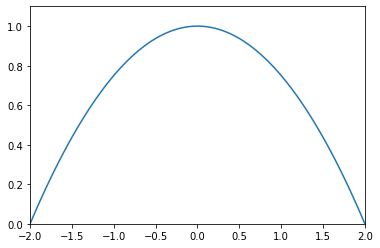

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
x = np.linspace(-2, 2, 100)
plt.xlim(-2, 2)
plt.ylim(0, 1.1)
plt.plot(x, 1-x**2/4)

Este es el Kernel. Apliquemos ahora postselección:

In [ ]:
def postselect(result_counts):
    total_samples = sum(result_counts.values())

    # definimos la función lambda que recupera solo los estados donde la ancilla está en el estado |0> 
    post_select = lambda counts: [(state, occurences) for state, occurences in counts.items() if state[-1] == '0']

    # realizamos post selección
    postselection = dict(post_select(result_counts))
    postselected_samples = sum(postselection.values())
    ancilla_post_selection = postselected_samples/total_samples

    print('La probabilidad de post selección en la ancilla fué ',round(ancilla_post_selection,3))
    retrieve_class = lambda binary_class: [occurences for state, occurences in postselection.items() if state[0] == str(binary_class)]

    prob_class0 = sum(retrieve_class(0))/postselected_samples
    prob_class1 = sum(retrieve_class(1))/postselected_samples

    print('Probabilidad de clase 0 es', round(prob_class0,3))
    print('Probabilidad de clase 1 es', round(prob_class1,3))

Para la primera instancia tenemos

In [ ]:
circuit_0 = interfere_data_and_test_instances(state_preparation_0, q, c, angles)
job = execute(circuit_0, backend)
result = job.result()
count = result.get_counts(circuit_0)
print(count)
postselect(count)

{'0100': 402, '1110': 283, '1011': 234, '1111': 12, '0001': 42, '0000': 47, '1010': 4}
Ancilla post-selection probability was found to be  0.719
Probability for class 0 is 0.61
Probability for class 1 is 0.39


Para la segunda

In [ ]:
angles = [test_angles[1], training_angle]
state_preparation_1 = prepare_state(q, c, angles)
circuit_1 = interfere_data_and_test_instances(state_preparation_1, q, c, angles)
job = execute(circuit_1, backend)
result = job.result()
count = result.get_counts(circuit_1)
print(count)
postselect(count)

{'0100': 512, '1011': 73, '1110': 333, '1010': 84, '1111': 22}
Ancilla post-selection probability was found to be  0.907
Probability for class 0 is 0.551
Probability for class 1 is 0.449


# Referencias



[1] M. Schuld, M. Fingerhuth, F. Petruccione. (2017). [Implementing a distance-based classifier with a quantum interference circuit](https://doi.org/10.1209/0295-5075/119/60002). *Europhysics Letters*, 119(6), 60002. <a id='1'></a>